<a id="table-of-contents"></a>

![Status: Complete](https://img.shields.io/badge/status-complete-brightgreen)
![Python](https://img.shields.io/badge/python-3.10-blue)
![Coverage](https://img.shields.io/badge/coverage-80%25-yellowgreen)
![License](https://img.shields.io/badge/license-MIT-green)

# 📖 Missing Values

[🗂️ Data Setup](#data-setup)  
- [📚 Import Libraries](#import-libraries)  
- [📄 Generate Dataset](#generate-dataset)

[🔍 Missing Value Detection](#missing-detection)  
- [🔥 Missing Values Heatmap](#missing-heatmap)
- [📊 Column-wise Missing Values](#col-detection)  
- [🔄 Row-wise Missing Values](#row-detection)  


[🧪 Imputation](#imputation)  
- [🔧 Deletion Methods](#deletion-methods)  
- [🔍 Simple Imputation](#simple-imputation)  
- [🤖 KNN Imputation](#knn-imputation)  
- [🔄 Iterative Imputation](#iterative-imputation)  
- [⏱️ Time Series Imputation](#timeseries-imputation)  
- [📈 Linear Regression Imputation](#linear-regression-imputation)

[📊 Post Imputation Checks](#post-treatment-analysis)

___

<a id="data-setup"></a>
# 🗂️ Data Setup

<a id="import-libraries"></a>
#### 📚 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a id="generate-dataset"></a>
#### 📄 Generate Dataset

In [2]:
import pandas as pd
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

# Number of rows in the dummy dataset
n_rows = 100

# Define possible values for categorical columns
stock_codes = ['85123A', '71053', '84406B', '84406G', '84406E']
descriptions = [
    'WHITE HANGING HEART T-LIGHT HOLDER',
    'WHITE METAL LANTERN',
    'CREAM CUPID HEARTS COAT HANGER',
    'PARTY BUNTING',
    'RED WOOLLY HOTTIE'
]
countries = ['United Kingdom', 'France', 'Germany', 'Spain', 'Netherlands']
customer_ids = [np.nan, 12346, 12347, 12348, 12349]

# Create dummy retail dataset and assign it to df
df = pd.DataFrame({
    'InvoiceNo': np.random.randint(10000, 20000, n_rows),
    'StockCode': np.random.choice(stock_codes, n_rows),
    'Description': np.random.choice(descriptions, n_rows),
    'Quantity': np.random.randint(1, 10, n_rows),
    'InvoiceDate': pd.date_range('2020-01-01', periods=n_rows, freq='D'),
    'UnitPrice': np.round(np.random.uniform(0.5, 20.0, n_rows), 2),
    'CustomerID': np.random.choice(customer_ids, n_rows),
    'Country': np.random.choice(countries, n_rows)
})

# Introduce additional random missingness into numeric columns (around 10% missing)
missing_mask = np.random.rand(n_rows) < 0.1  # roughly 10% missing
df.loc[missing_mask, 'Quantity'] = np.nan
missing_mask = np.random.rand(n_rows) < 0.1
df.loc[missing_mask, 'UnitPrice'] = np.nan

# Display a preview of the dummy dataset
print("Dummy Retail Dataset Preview:")
display(df.head())

# Optionally, show dataset info for a quick summary
print("\nDataset Info:")
df.info()


Dummy Retail Dataset Preview:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,17270,84406G,WHITE METAL LANTERN,5.0,2020-01-01,NaN,12349.0,France
1,10860,85123A,CREAM CUPID HEARTS COAT HANGER,8.0,2020-01-02,9.56,NaN,United Kingdom
2,15390,84406G,WHITE HANGING HEART T-LIGHT HOLDER,1.0,2020-01-03,13.17,12348.0,Germany
3,15191,71053,WHITE HANGING HEART T-LIGHT HOLDER,5.0,2020-01-04,1.44,NaN,Netherlands
4,15734,85123A,PARTY BUNTING,3.0,2020-01-05,19.01,NaN,France



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    100 non-null    int64         
 1   StockCode    100 non-null    object        
 2   Description  100 non-null    object        
 3   Quantity     87 non-null     float64       
 4   InvoiceDate  100 non-null    datetime64[ns]
 5   UnitPrice    94 non-null     float64       
 6   CustomerID   79 non-null     float64       
 7   Country      100 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 6.4+ KB


[Back to the top](#table-of-contents)
___


# 🔍 Missing Value Detection <a id="missing-detection"></a>


#### 🔥 Missing Values Heatmap <a id="missing-heatmap"></a>

This function displays a heatmap for the entire dataframe `df`, where the x-axis shows column names and the y-axis shows row indices. This visual summary provides an immediate overview of the missing data pattern across all observations.

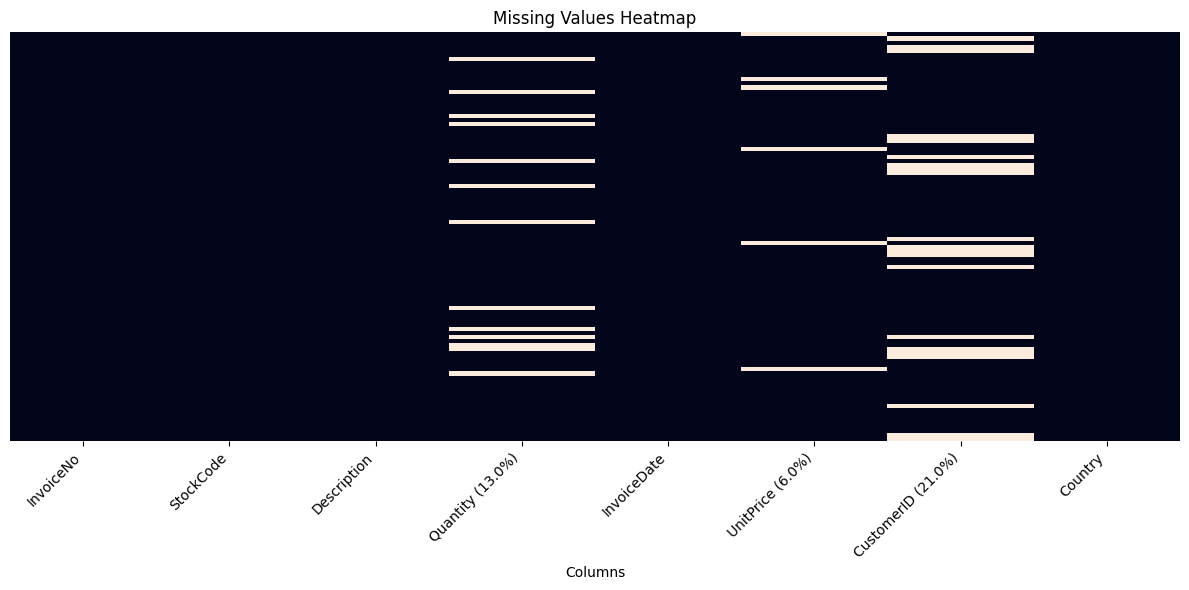

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def missing_values_heatmap(df):
    """
    Display a heatmap of missing values for the entire dataframe with enhanced x-axis labels.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        
    Behavior:
        - The x-axis displays column names with missing percentages in parentheses (if non-zero).
        - The y-axis labels (row indices) are hidden to reduce clutter.
    """
    # Compute missing percentages per column
    missing_percent = 100 * df.isnull().sum() / len(df)
    
    # Create custom x-axis labels: append missing percentage for non-zero values
    x_labels = [
        f"{col} ({round(missing_percent[col], 1)}%)" if missing_percent[col] > 0 else col 
        for col in df.columns
    ]
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.xlabel("Columns")
    # Set custom x-axis tick labels with rotation for better readability
    plt.xticks(ticks=plt.xticks()[0], labels=x_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
missing_values_heatmap(df)


#### 📊 Column-wise <a id="col-detection"></a>


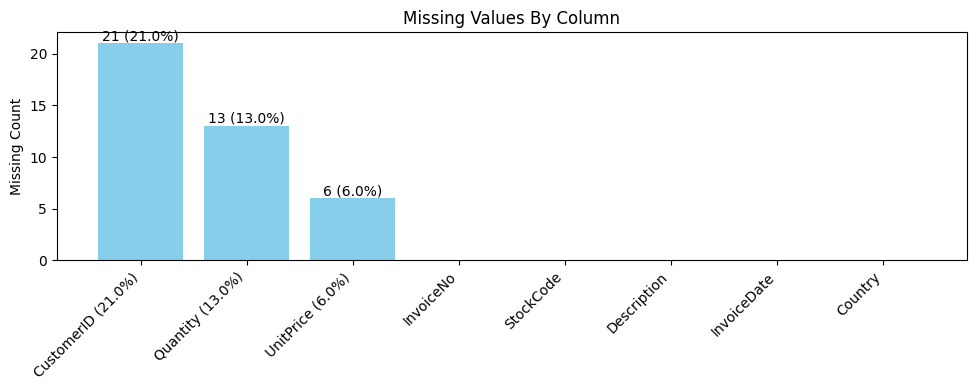

,Column_Name,Missing_Count,Missing_Percentage
0,CustomerID,21,21.0
1,Quantity,13,13.0
2,UnitPrice,6,6.0
3,InvoiceNo,0,0.0
4,StockCode,0,0.0
5,Description,0,0.0
6,InvoiceDate,0,0.0
7,Country,0,0.0


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_missing_by_column(df, visualize=False, plot_type='heatmap', ordering=False):
    """
    Generate a table of missing values by column and display a bar chart.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        visualize (bool): If True, displays a bar chart.
        plot_type (str): Ignored (always bar chart is used).
        ordering (bool): If True, orders the columns by descending missing count.
    
    Returns:
        pd.DataFrame: A DataFrame with columns 'Column_Name', 'Missing_Count', and 'Missing_Percentage'.
    """
    # Calculate missing counts and percentages.
    missing_counts = df.isnull().sum()
    missing_percent = 100 * missing_counts / len(df)
    
    # Create summary table with no index.
    summary = pd.DataFrame({
        'Missing_Count': missing_counts,
        'Missing_Percentage': missing_percent
    }).reset_index()
    summary.rename(columns={'index': 'Column_Name'}, inplace=True)
    
    # Order the summary if requested.
    if ordering:
        summary = summary.sort_values(by='Missing_Count', ascending=False).reset_index(drop=True)
    
    # Visualization: Bar chart only.
    if visualize:
        plt.figure(figsize=(10, 4))
        plt.title("Missing Values By Column")
        
        # Build custom x-axis labels: append missing percentage (if non-zero).
        column_labels = [
            f"{col} ({round(perc, 1)}%)" if perc > 0 else col
            for col, perc in zip(summary['Column_Name'], summary['Missing_Percentage'])
        ]
        
        bars = plt.bar(range(len(summary)), summary['Missing_Count'], color='skyblue')
        plt.xticks(range(len(summary)), column_labels, rotation=45, ha='right')
        plt.ylabel("Missing Count")
        
        # Annotate each bar with missing count and percentage.
        for i, (count, perc) in enumerate(zip(summary['Missing_Count'], summary['Missing_Percentage'])):
            if count > 0:
                annotation = f"{int(count)} ({round(perc, 1)}%)"
                plt.text(i, count, annotation, ha='center', va='bottom')
                
        plt.tight_layout()
        plt.show()
    
    return summary

# Example usage (the function call remains unchanged):
detect_missing_by_column(df, visualize=True, plot_type='heatmap', ordering=True)


#### 🔄 Row-wise <a id="row-detection"></a>

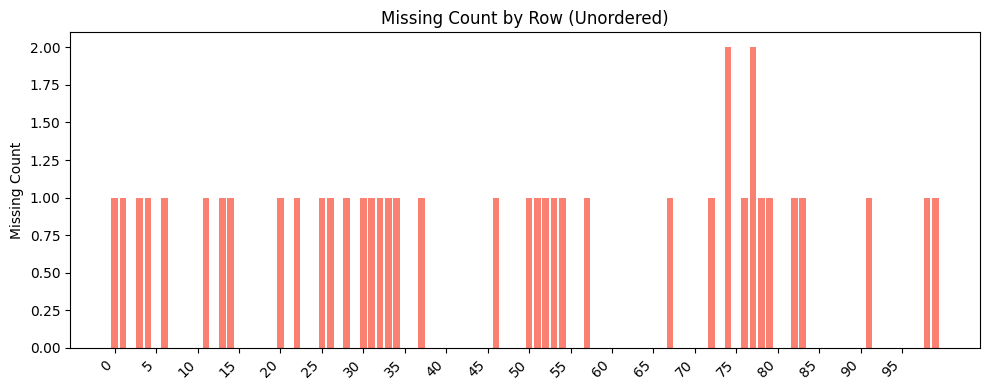

,Row_ID,Missing_Count
0,77,2
1,74,2
2,0,1
3,54,1
4,31,1


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def missing_count_by_row(df, visualize=False):
    """
    Compute and return a table of missing counts for each row.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        visualize (bool): If True, displays a bar chart of missing counts in the original (unsorted) order,
                          with x-axis ticks only at multiples of 5.
        
    Returns:
        pd.DataFrame: A DataFrame with two columns:
            - Row_ID: The original row index of df.
            - Missing_Count: The number of missing values in that row.
        The DataFrame is ordered by Missing_Count in descending order.
    """
    # Compute missing values count per row (unsorted)
    missing_counts_unsorted = df.isnull().sum(axis=1)
    
    # Create the result table and a sorted version.
    result = pd.DataFrame({
        "Row_ID": df.index,
        "Missing_Count": missing_counts_unsorted
    })
    result_sorted = result.sort_values(by="Missing_Count", ascending=False).reset_index(drop=True)
    
    # Visualization: Plot the unsorted missing counts (original order) with x-axis ticks only at multiples of 5.
    if visualize:
        plt.figure(figsize=(10, 4))
        plt.bar(range(len(missing_counts_unsorted)), missing_counts_unsorted, color="salmon")
        
        # Define tick positions: multiples of 5.
        tick_positions = list(range(0, len(df), 5))
        tick_labels = [df.index[i] for i in tick_positions]
        
        plt.xticks(tick_positions, tick_labels, rotation=45, ha="right")
        plt.ylabel("Missing Count")
        plt.title("Missing Count by Row (Unordered)")
        plt.tight_layout()
        plt.show()
    
    return result_sorted

# Example usage:
row_missing_counts = missing_count_by_row(df, visualize=True)
row_missing_counts.head()


[Back to the top](#table-of-contents)
___


<a id="imputation"></a>
# 🧪 Missing Value Treatment (Imputation)



<a id="deletion-methods-theory"></a>
### 🔧 Deletion Methods Theory

<details>
  <summary><strong>📖 Click to Expand</strong></summary>

- **⚙️ Algorithm / Inner-Workings:**  
  Rows (or columns) with missing values are completely removed from the dataset by using functions like `dropna()`. No attempt is made to recover or impute the missing data.

- **✅ When to Use:**  
  - When the amount of missing data is very small, so that removal doesn't significantly impact sample size.
  - When missingness is assumed to be completely at random.
  - When a quick, straightforward solution is needed without the complexity of imputation.

- **⚖️ Trade-Offs:**  
  - **Pros:**  
    - Extremely simple to implement.  
    - Removes uncertainty associated with missing values.  
  - **Cons:**  
    - May result in significant data loss if missingness is high.  
    - Can introduce bias if the missing data are not random.

</details>


In [6]:
def deletion_imputation(df, target='rows'):
    """
    Delete rows or columns with missing values.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        target (str): Determines whether to delete rows or columns with missing values.
                      Use 'rows' to remove rows (default) or 'columns' to remove columns.

    Returns:
        pd.DataFrame: DataFrame with the specified rows or columns removed.
    """
    if target == 'rows':
        return df.dropna(axis=0)
    elif target == 'columns':
        return df.dropna(axis=1)
    else:
        raise ValueError("target must be 'rows' or 'columns'")

# Example usage:
# To delete rows with missing values:
# df_imputed = deletion_imputation(df, target='rows')
#
# To delete columns with missing values:
# df_imputed = deletion_imputation(df, target='columns')


<a id="simple-imputation"></a>
#### 🔍 Simple Imputation

<details>
  <summary><strong>📖 Click to Expand: Simple Imputation Details</strong></summary>

  ##### 🤖 Algorithm / Inner-Workings:
  Simple imputation calculates a statistic (mean for continuous, median for skewed, or mode for categorical data) using the observed values in a column. This statistic is then used to fill in all missing entries in that column.

  ##### ✅ When to Use:
  - When the proportion of missing data is low, so that a single summary statistic adequately represents the data.
  - When a quick, baseline imputation is needed without introducing complex modeling.

  ##### ⚖️ Trade-Offs:
  - ##### 👍 Pros:
    - Easy and fast to implement.
    - Retains the dataset’s dimensions.
  - ##### 👎 Cons:
    - Can reduce variability in the data.
    - May introduce bias if the missing data is not missing completely at random.
  
</details>

In [7]:
def simple_imputation(df, column, method='mean'):
    """
    Impute missing values in a single specified column using a simple method.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        column (str): Column name to impute.
        method (str): Imputation method; must be 'mean', 'median', or 'mode'.
    
    Returns:
        pd.DataFrame: DataFrame with missing values imputed in the specified column.
    """
    if method == 'mean':
        df[column].fillna(df[column].mean(), inplace=True)
    elif method == 'median':
        df[column].fillna(df[column].median(), inplace=True)
    elif method == 'mode':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        raise ValueError("Method must be 'mean', 'median', or 'mode'")
    return df

# Example usage:
# df_imputed = df.copy()
# for col in ['col1', 'col2']:
#     df_imputed = simple_imputation(df_imputed, column=col, method='mean')

<a id="knn-imputation"></a>
#### 🤖 KNN Imputation

<details>
  <summary><strong>📖 Click to Expand</strong></summary>

  ##### 🤖 Algorithm / Inner-Workings:
  KNN imputation identifies the *k* nearest neighbors using a distance metric (typically Euclidean) based on available numeric features. For each missing value, it calculates the mean (or median) of that feature from the selected neighbors to fill in the gap.

  ##### ✅ When to Use:
  - When the dataset has strong relationships among its numeric features.
  - When the missingness mechanism is influenced by similarities among observations.
  - Suitable when computational resources allow, as KNN can be intensive on large datasets.

  ##### ⚖️ Trade-Offs:
  - ##### 👍 Pros:
    - Leverages the local data structure for nuanced imputation.
    - Can yield accurate estimates if neighboring observations are similar.
  - ##### 👎 Cons:
    - Computationally intensive for large datasets.
    - Sensitive to the choice of *k* and the distance metric.
  
</details>


In [ ]:
def knn_imputation(df, n_neighbors=5):
    """
    Impute missing values using KNN imputation on numeric columns.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        n_neighbors (int): Number of neighbors for KNN imputation.

    Returns:
        pd.DataFrame: DataFrame with numeric missing values imputed via KNN.
    """
    from sklearn.impute import KNNImputer

    numeric_cols = df.select_dtypes(include=['number']).columns
    imputer = KNNImputer(n_neighbors=n_neighbors)
    # Replace the numeric columns in the original dataframe with imputed values.
    df[numeric_cols] = pd.DataFrame(imputer.fit_transform(df[numeric_cols]),
                                    columns=numeric_cols,
                                    index=df.index)
    return df

# Example usage:
# df_imputed = knn_imputation(df, n_neighbors=5)

: 

<a id="iterative-imputation"></a>
#### 🔄 Iterative Imputation

<details>
  <summary><strong>📖 Click to Expand</strong></summary>

  ##### 🤖 Algorithm / Inner-Workings:
  Iterative imputation models each variable with missing values as a function of other variables. It starts with an initial imputation (often simple methods) and then cycles through each variable, updating the imputation through regression models until convergence is achieved.

  ##### ✅ When to Use:
  - When complex multivariate relationships exist in the data.
  - When it's important to preserve correlations among variables.
  - When simple imputation methods might distort the underlying data structure.

  ##### ⚖️ Trade-Offs:
  - ##### 👍 Pros:
    - Provides robust imputations by leveraging inter-variable relationships.
    - Often yields better estimates in datasets with complex patterns.
  - ##### 👎 Cons:
    - More computationally demanding.
    - Requires careful tuning and diagnostic checking to avoid overfitting.
  
</details>


In [ ]:
def iterative_imputation(df, random_state=42, max_iter=100):
    """
    Impute missing values using iterative (model-based) imputation on numeric columns.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        random_state (int): Random state for reproducibility.
        max_iter (int, optional): Maximum number of imputation rounds (default: 100).
    
    Returns:
        pd.DataFrame: DataFrame with missing values imputed iteratively.
    """
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

    numeric_cols = df.select_dtypes(include=['number']).columns
    imputer = IterativeImputer(random_state=random_state, max_iter=max_iter)
    df[numeric_cols] = pd.DataFrame(imputer.fit_transform(df[numeric_cols]),
                                    columns=numeric_cols,
                                    index=df.index)
    return df

# Example usage:
df_imputed = iterative_imputation(df, random_state=42)

<a id="timeseries-imputation"></a>
#### ⏱️ Time Series Imputation (Smoothing / Carry-Forward/Backward)

<details>
  <summary><strong>📖 Click to Expand</strong></summary>

  ##### 🤖 Algorithm / Inner-Workings:
  Time series imputation utilizes the sequential nature of the data. It often applies forward fill (carry-forward) or backward fill (carry-backward) methods, assuming that adjacent time points are correlated and that the most recent or subsequent observation can serve as a reasonable estimate.

  ##### ✅ When to Use:
  - When data is time-dependent and observations are sequential.
  - When adjacent values are expected to be similar due to trends or seasonality.
  - When a simple, fast imputation method is sufficient.

  ##### ⚖️ Trade-Offs:
  - ##### 👍 Pros:
    - Simple and intuitive.
    - Preserves the temporal order and underlying trends.
  - ##### 👎 Cons:
    - May propagate errors if the carrying value is an outlier.
    - Not ideal for data with abrupt changes or irregular time intervals.
  
</details>


In [ ]:
def timeseries_imputation(df, method='ffill', target_col=None):
    """
    Impute missing values in a time series dataframe (or column) using forward fill or backward fill.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        method (str): The imputation method to use. Options:
            - 'ffill': Forward Fill – propagates the last valid observation forward to fill missing values.
            - 'bfill': Backward Fill – uses the next valid observation to fill missing values.
            These methods assume that adjacent time steps are similar.
        target_col (str or None): Specifies a single column to impute. If None, imputation is applied to the entire dataframe.


    Returns:
        pd.DataFrame: DataFrame with missing values imputed using the selected method.
    """
    if method not in ['ffill', 'bfill']:
        raise ValueError("Method must be 'ffill' or 'bfill'")
    
    if target_col:
        df[target_col].fillna(method=method, inplace=True)
    else:
        df.fillna(method=method, inplace=True)
    
    return df

# Example usage:
# To impute the entire dataframe:
# df_imputed = timeseries_imputation(df, method='ffill')
#
# To impute only a specific column, e.g., 'col1':
# df_imputed = timeseries_imputation(df, method='bfill', target_col='col1')


<a id="linear-regression-imputation"></a>
#### 📈 Linear Regression Imputation

<details>
  <summary><strong>📖 Click to Expand</strong></summary>

  ##### 🤖 Algorithm / Inner-Workings:
  Linear regression imputation builds a regression model using observed values from predictor columns to estimate missing values in the target column. The model is trained on the subset of data with non-missing target values and then used to predict missing entries.

  ##### ✅ When to Use:
  - When there is a strong linear relationship between the target variable and other features.
  - When leveraging additional data can improve the accuracy of imputations.
  - When simple imputation methods might fail to capture underlying dependencies.

  ##### ⚖️ Trade-Offs:
  - ##### 👍 Pros:
    - Provides improved accuracy by using relationships among variables.
    - Helps maintain the covariance structure between the target and predictors.
  - ##### 👎 Cons:
    - Assumes a linear relationship, which may not always hold.
    - Can underestimate variability, potentially leading to overconfident imputed values.
  
</details>


In [ ]:
def linear_regression_imputation(df, target_col, predictor_cols):
    """
    Impute missing values in a target column using linear regression based on other predictor columns.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        target_col (str): The column to impute.
        predictor_cols (list of str): List of column names used as predictors.
    
    Returns:
        pd.DataFrame: DataFrame with missing values in the target column imputed.
    """
    from sklearn.linear_model import LinearRegression

    # Split the data into rows with non-missing and missing values in the target column.
    train_data = df[df[target_col].notna()]
    test_data = df[df[target_col].isna()]
    
    # If there are no missing values to impute, return the original dataframe.
    if test_data.empty:
        return df
    
    # Train the regression model using the non-missing rows.
    model = LinearRegression()
    model.fit(train_data[predictor_cols], train_data[target_col])
    
    # Predict missing values for the target column.
    predicted_values = model.predict(test_data[predictor_cols])
    df.loc[test_data.index, target_col] = predicted_values
    
    return df

# Example usage:
# df_imputed = linear_regression_imputation(df, target_col='target', predictor_cols=['col1', 'col2'])

[Back to the top](#table-of-contents)
___


<a id="post-treatment-analysis"></a>
# 📊 Post Imputation Checks

Use the same detection functions from the pre-treatment section to verify that missing values have been appropriately handled.


In [ ]:
missing_values_heatmap(df_imputed)

In [ ]:
detect_missing_by_column(df_imputed, visualize=True, plot_type='bar', ordering=True)

In [ ]:
missing_count_by_row(df_imputed, visualize=True)

[Back to the top](#table-of-contents)
___
